<a href="https://colab.research.google.com/github/zxcv1230174/colorectal_histology/blob/main/colorectal_histology%E5%B0%88%E9%A1%8C%E6%A8%A1%E5%9E%8B%E8%A8%93%E7%B7%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import shutil
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
import tensorflow_hub as hub
import sklearn.metrics as skm
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models, callbacks

# 載入資料

In [3]:
# 將訓練資料拆分成7:3，分別是訓練與測試集，並且取得Info
[train_ds, valid_ds, test_ds], info = tfds.load('colorectal_histology',
                            split=['train[:70%]','train[70%:85%]', 'train[85%:]'],
                            shuffle_files=True,
                            with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/5000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteWOYRHP/colorectal_histology-train.tfr…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


In [4]:
# 參數設定
#input_shapes = info.features[info.supervised_keys[0]].shape
input_shapes = (224,224,3)
img_size = input_shapes[:2]
batch_size = 32
epoch = 50

In [5]:
# 預處理函數
def preprocess_data(data):
    image = data['image']
    label = data['label']
    # 將圖片大小調整為指定大小,並正規化像素值至 [0, 1]
    image = tf.image.resize(image, img_size) / 255.0
    return image, label

# 將預處理函數應用到數據集，並將資料分批
train_data = train_ds.map(preprocess_data).batch(batch_size)
valid_data = valid_ds.map(preprocess_data).batch(batch_size)
test_data = test_ds.map(preprocess_data).batch(batch_size)

# EarlyStopping設定
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# 定義模型

In [ ]:
# 定義 CNN 模型 (用於callbacks)
model_1 = models.Sequential()
model_1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shapes))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(256, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(512, (3, 3), activation='relu'))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Flatten())
model_1.add(layers.Dense(256, activation='relu'))
model_1.add(layers.Dense(128, activation='relu'))
model_1.add(layers.Dense(info.features['label'].num_classes, activation='softmax'))
model_1.summary()
# 編譯模型
model_1.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 26, 26, 128)       0

In [ ]:
# 建立 VGG16 模型
VGG16_model = tf.keras.applications.VGG16(input_shape=input_shapes, include_top=False, weights='imagenet')
# 凍結 VGG16 的權重
VGG16_model.trainable = False

model_2 = models.Sequential()
model_2.add(VGG16_model)
model_2.add(layers.Flatten())
model_2.add(layers.Dense(256, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(info.features['label'].num_classes, activation='softmax'))
model_2.summary()
# 編譯模型
model_2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 [==============================] - 4s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 21139528 (80.64 MB)
Trainable params: 6424840 (24.51 MB)
Non-trainable params: 14714688 (56.13 MB)
________

In [ ]:
# 建立 VGG19 模型
VGG19_model = tf.keras.applications.VGG19(input_shape=input_shapes, include_top=False, weights='imagenet')
# 凍結 VGG19 的權重
VGG19_model.trainable = False

model_3 = models.Sequential(VGG19_model)
model_3.add(layers.Flatten())
model_3.add(layers.Dense(256, activation='relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(info.features['label'].num_classes, activation='softmax'))
model_3.summary()
# 編譯模型
model_3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

80134624/80134624 [==============================] - 4s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_2 (Flatten)         (None, 25088)             0         
                                                                 
 dense_5 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 26449224 (100.90 MB)
Trainable params: 6424840 (24.51 MB)
Non-trainable params: 20024384 (76.39 MB)
_______

In [6]:
# 建立 DenseNet121 模型
DN121_model = tf.keras.applications.DenseNet121(input_shape=input_shapes, include_top=False, weights='imagenet')
# 凍結 DenseNet121 的權重
DN121_model.trainable = False

model_4 = models.Sequential(DN121_model)
model_4.add(layers.GlobalAveragePooling2D())
model_4.add(layers.Dense(256, activation='relu'))
model_4.add(layers.Dropout(0.5))
model_4.add(layers.Dense(info.features['label'].num_classes, activation='softmax'))
model_4.summary()
# 編譯模型
model_4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

29084464/29084464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (  (None, 1024)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               262400    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 2056      
                                                                 
Total params: 7301960 (27.85 MB)
Trainable params: 264456

# 訓練模型

In [ ]:
# 使用 CNN

history_1 = model_1.fit(train_data, epochs=epoch, validation_data=valid_data, callbacks=[early_stopping])

Epoch 1/50
110/110 [==============================] - 17s 87ms/step - loss: 1.4761 - accuracy: 0.3549 - val_loss: 1.1401 - val_accuracy: 0.5200
Epoch 2/50
110/110 [==============================] - 7s 61ms/step - loss: 0.9921 - accuracy: 0.5697 - val_loss: 0.9136 - val_accuracy: 0.6440
Epoch 3/50
110/110 [==============================] - 7s 63ms/step - loss: 0.8963 - accuracy: 0.6331 - val_loss: 0.8482 - val_accuracy: 0.6680
Epoch 4/50
110/110 [==============================] - 8s 71ms/step - loss: 0.8130 - accuracy: 0.6780 - val_loss: 0.7819 - val_accuracy: 0.6840
Epoch 5/50
110/110 [==============================] - 7s 60ms/step - loss: 0.6999 - accuracy: 0.7329 - val_loss: 0.7469 - val_accuracy: 0.7027
Epoch 6/50
110/110 [==============================] - 7s 65ms/step - loss: 0.7038 - accuracy: 0.7131 - val_loss: 0.6797 - val_accuracy: 0.7253
Epoch 7/50
110/110 [==============================] - 8s 71ms/step - loss: 0.6752 - accuracy: 0.7357 - val_loss: 0.7265 - val_accuracy: 0.708

In [ ]:
# 使用 VGG16
history_2 = model_2.fit(train_data, epochs=epoch, validation_data=valid_data, callbacks=[early_stopping])

Epoch 1/50
110/110 [==============================] - 39s 250ms/step - loss: 1.2055 - accuracy: 0.6063 - val_loss: 0.6627 - val_accuracy: 0.7773
Epoch 2/50
110/110 [==============================] - 19s 172ms/step - loss: 0.7265 - accuracy: 0.7291 - val_loss: 0.5077 - val_accuracy: 0.8360
Epoch 3/50
110/110 [==============================] - 19s 175ms/step - loss: 0.5892 - accuracy: 0.7929 - val_loss: 0.4402 - val_accuracy: 0.8480
Epoch 4/50
110/110 [==============================] - 17s 156ms/step - loss: 0.5127 - accuracy: 0.8151 - val_loss: 0.4263 - val_accuracy: 0.8600
Epoch 5/50
110/110 [==============================] - 19s 175ms/step - loss: 0.4621 - accuracy: 0.8346 - val_loss: 0.4210 - val_accuracy: 0.8560
Epoch 6/50
110/110 [==============================] - 17s 156ms/step - loss: 0.4256 - accuracy: 0.8423 - val_loss: 0.3928 - val_accuracy: 0.8680
Epoch 7/50
110/110 [==============================] - 17s 158ms/step - loss: 0.3775 - accuracy: 0.8551 - val_loss: 0.3822 - val_ac

In [ ]:
# 使用 VGG19
history_3 = model_3.fit(train_data, epochs=epoch, validation_data=valid_data, callbacks=[early_stopping])

Epoch 1/50
110/110 [==============================] - 24s 200ms/step - loss: 1.3875 - accuracy: 0.5529 - val_loss: 0.7701 - val_accuracy: 0.7613
Epoch 2/50
110/110 [==============================] - 23s 209ms/step - loss: 0.8285 - accuracy: 0.6929 - val_loss: 0.5576 - val_accuracy: 0.8333
Epoch 3/50
110/110 [==============================] - 22s 198ms/step - loss: 0.6832 - accuracy: 0.7417 - val_loss: 0.5524 - val_accuracy: 0.8373
Epoch 4/50
110/110 [==============================] - 23s 205ms/step - loss: 0.6361 - accuracy: 0.7594 - val_loss: 0.4803 - val_accuracy: 0.8480
Epoch 5/50
110/110 [==============================] - 22s 196ms/step - loss: 0.5540 - accuracy: 0.7903 - val_loss: 0.4303 - val_accuracy: 0.8493
Epoch 6/50
110/110 [==============================] - 22s 197ms/step - loss: 0.5090 - accuracy: 0.8063 - val_loss: 0.4520 - val_accuracy: 0.8400
Epoch 7/50
110/110 [==============================] - 22s 204ms/step - loss: 0.5189 - accuracy: 0.7994 - val_loss: 0.4509 - val_ac

In [ ]:
# 使用 DenseNet121
history_4 = model_4.fit(train_data, epochs=epoch, validation_data=valid_data, callbacks=[early_stopping])

Epoch 1/50
110/110 [==============================] - 41s 243ms/step - loss: 0.7967 - accuracy: 0.7220 - val_loss: 0.4344 - val_accuracy: 0.8653
Epoch 2/50
110/110 [==============================] - 13s 113ms/step - loss: 0.4501 - accuracy: 0.8471 - val_loss: 0.3472 - val_accuracy: 0.8907
Epoch 3/50
110/110 [==============================] - 12s 112ms/step - loss: 0.3595 - accuracy: 0.8763 - val_loss: 0.3254 - val_accuracy: 0.8933
Epoch 4/50
110/110 [==============================] - 12s 110ms/step - loss: 0.3051 - accuracy: 0.8957 - val_loss: 0.3026 - val_accuracy: 0.9080
Epoch 5/50
110/110 [==============================] - 14s 124ms/step - loss: 0.2679 - accuracy: 0.9074 - val_loss: 0.2844 - val_accuracy: 0.9160
Epoch 6/50
110/110 [==============================] - 12s 107ms/step - loss: 0.2441 - accuracy: 0.9166 - val_loss: 0.2881 - val_accuracy: 0.9080
Epoch 7/50
110/110 [==============================] - 12s 113ms/step - loss: 0.2257 - accuracy: 0.9274 - val_loss: 0.2875 - val_ac

# 儲存模型權重

In [ ]:
# 最終以使用DenseNet121權重作為網頁式直腸癌識別模型
model_4.save_weights('DenseNet121_model_weights.h5')
# 加載模型權重
# model_4.load_weights('DenseNet121_model_weights.h5')

# 評估模型

In [ ]:
model_list = [model_1, model_2, model_3, model_4]
result = pd.DataFrame(columns=['Accuracy', 'Loss'])

for model in model_list:
  test_loss, test_acc = model.evaluate(test_data)
  result = pd.concat([result, pd.DataFrame({'Accuracy': [test_acc], 'Loss': [test_loss]})], ignore_index=True)

24/24 [==============================] - 2s 88ms/step - loss: 0.1921 - accuracy: 0.9320


In [ ]:
result.index = ['CNN', 'VGG16', 'VGG19', 'DenseNet121']

result

,Accuracy,Loss
CNN,0.790667,0.594068
VGG16,0.878667,0.379814
VGG19,0.862667,0.408321
DenseNet121,0.932000,0.192096


In [8]:
# 載入模型權重
model_4.load_weights('DenseNet121_model_weights.h5')

# 載入待辨識的圖像
img_path = '/content/valid/testA_12_jpg.rf.f42c182cb0e490675c3c6a3c075b31a4.jpg'  # 替換為你的圖像路徑
img = image.load_img(img_path, target_size=(224, 224), color_mode='rgb')  # 載入圖像並轉換為彩色模式
x_new = image.img_to_array(img)
x_new = np.expand_dims(x_new, axis=0) / 255.0

In [9]:
# 進行預測
predictions = model_4.predict(x_new)
print("predictions:", predictions)

# 找出最大概率的類別索引
predicted_class = np.argmax(predictions)
print("predictions:", predicted_class)

# 定義類別標籤列表
labels = ['tumour epithelium', 'simple stroma', 'complex stroma', 'immune cell conglomerates', 'debris and mucus', 'mucosal glands', 'adipose tissue', 'background']

# 輸出最大概率的類別索引
print("predictions:", labels[predicted_class])

1/1 [==============================] - 5s 5s/step
predictions: [[0.08329756 0.23932733 0.03633929 0.20010993 0.42180952 0.01757969
  0.00099614 0.00054051]]
predictions: 4
predictions: debris and mucus


In [23]:
# 直接使用預處理後的 test_data 進行評估
score = model_4.evaluate(test_data)
print("Loss:", score[0])
print("Accuracy:", score[1])

# 獲取預測結果和真實標籤
y_pred = []
y_true = []

for images, labels in test_data:
    predictions = model_4.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    y_true.extend(labels.numpy())

# 計算混淆矩陣
conf_matrix = confusion_matrix(y_true, y_pred)

24/24 [==============================] - 3s 104ms/step - loss: 0.2133 - accuracy: 0.9213
Loss: 0.21334430575370789
Accuracy: 0.9213333129882812
1/1 [==============================] - 0s 32ms/step


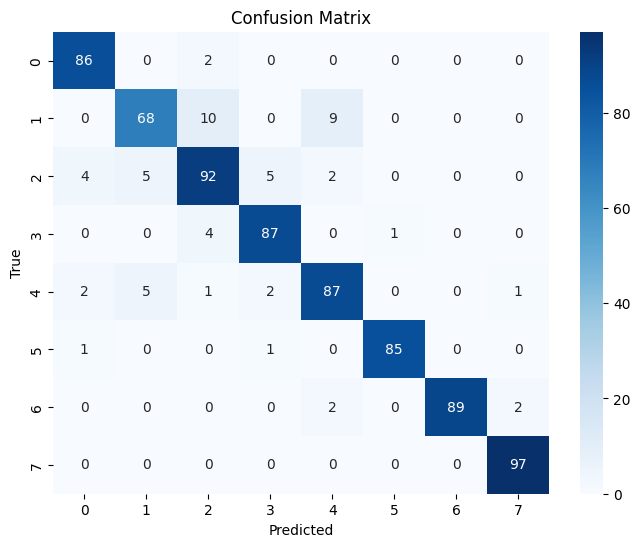

In [22]:
# 可視化混淆矩陣
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_4.save('DenseNet121_model.h5')

# 載入訓練好的模型
model = load_model('DenseNet121_model.h5')

# 將模型保存為 SavedModel 格式
tf.saved_model.save(model, 'DenseNet121_model_saved_model')

In [ ]:
shutil.make_archive('DenseNet121_model_saved_model', 'zip', '/content')

'/content/DenseNet121_model_saved_model.zip'